In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]
from scipy.ndimage import gaussian_filter

In [2]:
# Initialize LineModel with default model
m = lim()

In [3]:
m_noise = lim('Lichen',doSim=True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [4]:
noisy_2 = m_noise.noise_added_map
nonoise_2 = m_noise.maps

Loading .npz catalogues...


In [5]:
m_noise.update(tobs=40000*u.hr)

In [6]:
noisy_40 = m_noise.noise_added_map
nonoise_40 = m_noise.maps

Loading .npz catalogues...


In [7]:
m_noise.reset()

In [9]:
ind = 3

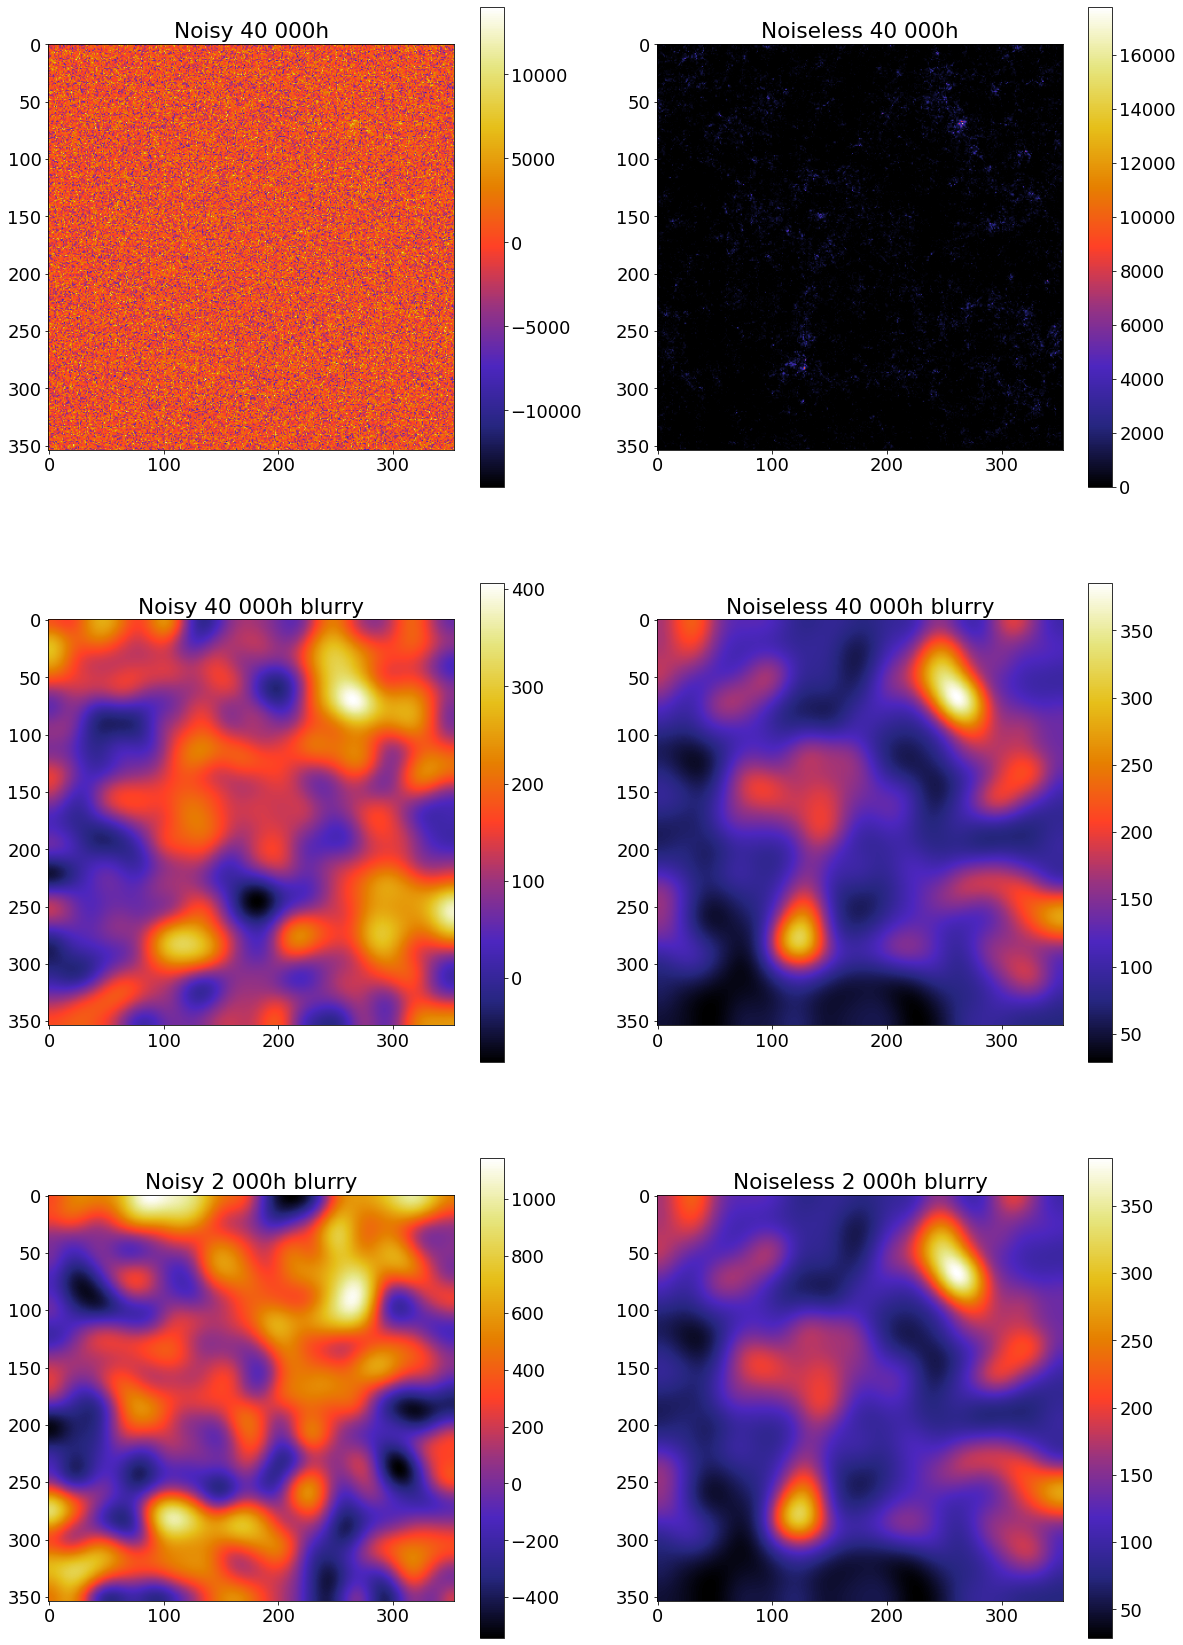

In [10]:
fig , axes = plt.subplots(nrows=3, ncols=2, figsize=(20,30))

plt.subplot(321)
plt.imshow(noisy_40[:,:, ind], cmap = 'CMRmap') 
plt.title('Noisy 40 000h') 
plt.colorbar()

plt.subplot(322)
plt.imshow(nonoise_40[:,:, ind], cmap = 'CMRmap') 
plt.title('Noiseless 40 000h')
plt.colorbar()

plt.subplot(323)
plt.imshow(gaussian_filter((noisy_40[..., ind]),15), cmap = 'CMRmap') 
plt.title('Noisy 40 000h blurry') 
plt.colorbar()

plt.subplot(324)
plt.imshow(gaussian_filter((nonoise_40[..., ind]),15), cmap = 'CMRmap') 
plt.title('Noiseless 40 000h blurry') 
plt.colorbar()

plt.subplot(325)
plt.imshow(gaussian_filter((noisy_2[..., ind]),15), cmap = 'CMRmap') 
plt.title('Noisy 2 000h blurry') 
plt.colorbar()

plt.subplot(326)
plt.imshow(gaussian_filter((nonoise_2[..., ind]),15), cmap = 'CMRmap') 
plt.title('Noiseless 2 000h blurry') 
plt.colorbar()

## Modeling HOD

In [20]:
halo_ms = m_noise.halos.M

In [12]:
import math

From Harikane+2016:

$N_c(M_h) = \frac{1}{2} [1 + \rm{erf}(\frac{\rm{log(M_h)} - \rm{log(M_{min})}}{\sigma_{log M}})]$

$N_s(M_h) = N_c(M_h)(\frac{M_h - M_0}{M_1'})^{\alpha}$

In [21]:
log_Mmin = 11.03 # at redshift = 5.9 and fainter UV threshold
sig_logM = 0.2

In [22]:
def N_c(M_h, sig, logM_min):
    
    return (1/2)*(1 + math.erf((np.log10(M_h) - logM_min)/(sig)))

In [89]:
N_cen = [0 for i in range(len(halo_ms))]
for i in range(len(halo_ms)):
    N_cen[i] = N_c(halo_ms[i], sig_logM, log_Mmin)

Text(0.5, 1.0, '$N_{cen}$ as a function of $M_h$')

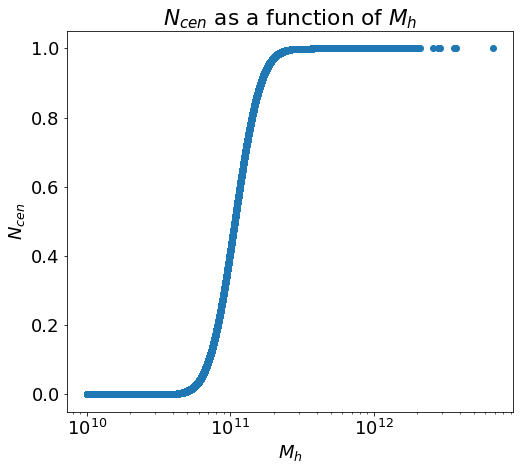

In [90]:
plt.scatter(halo_ms, N_cen)
plt.xscale('log')
plt.xlabel(r'$M_h$')
plt.ylabel(r'$N_{cen}$')
plt.title(r'$N_{cen}$ as a function of $M_h$')

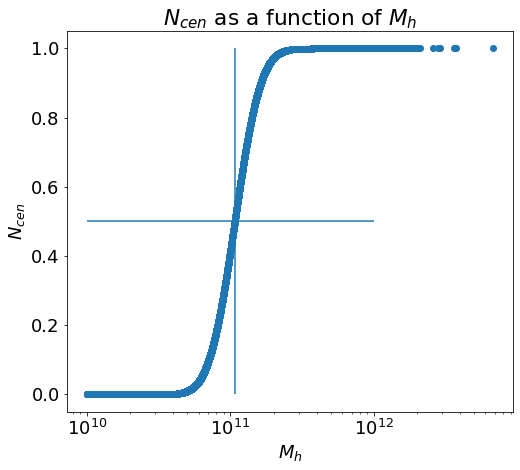

In [91]:
plt.scatter(halo_ms, N_central)
plt.xscale('log')
plt.xlabel(r'$M_h$')
plt.ylabel(r'$N_{cen}$')
plt.title(r'$N_{cen}$ as a function of $M_h$')
plt.vlines(x = 10**log_Mmin, ymin = 0, ymax  = 1)
plt.hlines(y = 0.5, xmin = 10**10, xmax = 10**12)

Martinez-Manso et al. (2015):

$\rm{log}(M_1') = 1.18 \rm{log}(M_{min}) - 1.28$

Conroy et al. (2006):

$\rm{log}(M_0) = 0.76 \rm{log}(M_1') + 2.3$

In [36]:
def m1(logM_min):
    return 10**(1.18*logM_min - 1.28)

In [37]:
def m0(logM_min):
    return 10**(0.76*(1.18*logM_min - 1.28) + 2.3)

In [57]:
log_Mmin = 11.03
sig_logM = 0.2
alpha = 1.0
M_1 = m1(log_Mmin)
M_0 = m0(log_Mmin)

In [58]:
def N_s(M_h, sig, logM_min, M1, M0, alph):
    
    return N_c(M_h, sig, logM_min)*(((M_h - M0)/M1)**alph)

In [59]:
N_sat = [0 for i in range(len(halo_ms))]
for i in range(len(halo_ms)):
    N_sat[i] = N_s(halo_ms[i], sig_logM, log_Mmin, M_1, M_0, alpha)

Text(0.5, 1.0, '$N_{sat}$ as a function of $M_h$')

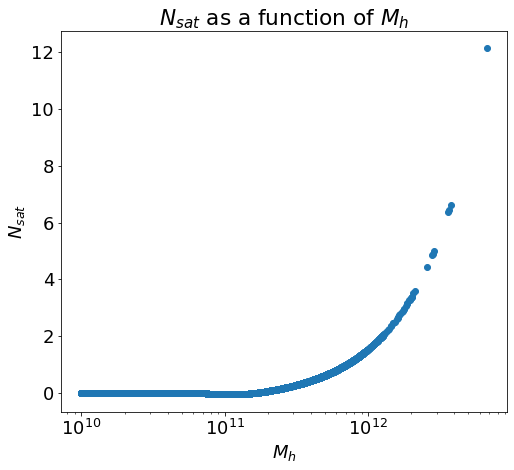

In [73]:
plt.scatter(halo_ms, N_sat)
plt.xscale('log')
plt.xlabel(r'$M_h$')
plt.ylabel(r'$N_{sat}$')
plt.title(r'$N_{sat}$ as a function of $M_h$')

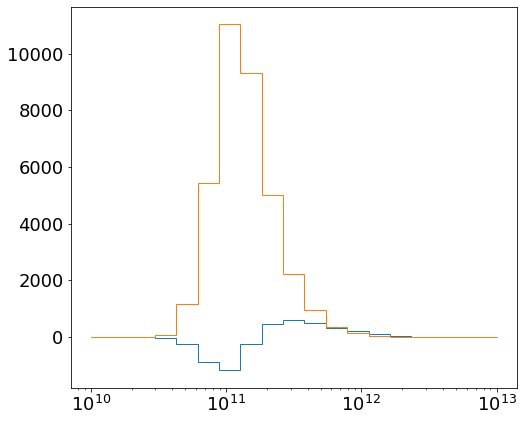

In [76]:
plt.hist(halo_ms, weights = N_sat, bins = np.logspace(10, 13, 20), histtype='step')
plt.hist(halo_ms, weights = N_central, bins = np.logspace(10, 13, 20), histtype='step')
plt.xscale('log')

In [97]:
neg = np.array(N_sat) < 0
pos = np.array(N_sat) > 0
print(len(N_sat))
print(len(np.array(N_sat)[neg]))
print(len(np.array(N_sat)[pos]))

1861929
1850675
11254


In [92]:
neg = np.array(N_cen) < 0
pos = np.array(N_cen) > 0
print(len(N_cen))
print(len(np.array(N_cen)[neg]))
print(len(np.array(N_cen)[pos]))

1861929
0
1861929


In [87]:
len(halo_ms)

1861929

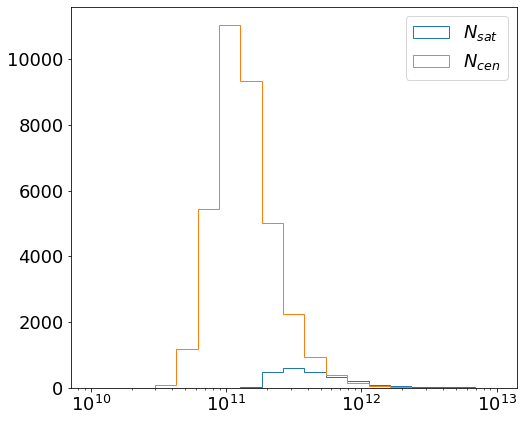

In [98]:
plt.hist(halo_ms[pos], weights = np.array(N_sat)[pos], bins = np.logspace(10, 13, 20), histtype='step', label = r'$N_{sat}$')
plt.hist(halo_ms, weights = N_central, bins = np.logspace(10, 13, 20), histtype='step', label = r'$N_{cen}$')
plt.xscale('log')
plt.legend()